## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

from sklearn.model_selection import KFold,StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from imblearn import over_sampling

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report,confusion_matrix



import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Here we will observe the distribution of our classes

In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

print("Percentage normal transactions: ",round(normal_share,2))
print("Percentage fraud transactions: ",round(fraud_share,2))

Percentage normal transactions:  99.83
Percentage fraud transactions:  0.17


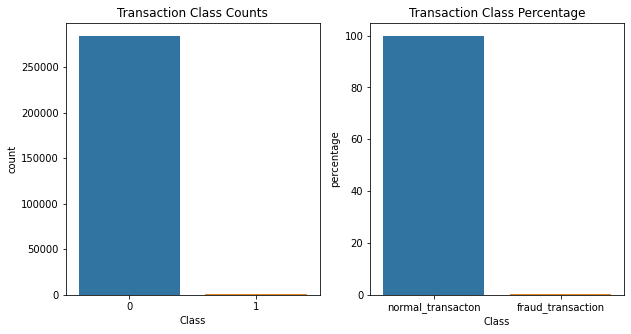

In [7]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
# mypalette = sns.color_palette()


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Transaction Class Counts")
sns.countplot(df.Class)

fraud_percentage = pd.DataFrame({'Class':['normal_transacton','fraud_transaction'],'percentage':[normal_share,fraud_share]})
plt.subplot(1,2,2)
plt.title("Transaction Class Percentage")
sns.barplot(x = fraud_percentage.Class,y=fraud_percentage.percentage)

plt.show()

In [8]:
timeDelta = pd.to_timedelta(df['Time'], unit='s')
df['TimeHours'] = (timeDelta.dt.components.hours).astype(int)
df['TimeDays'] = (timeDelta.dt.components.days).astype(int)

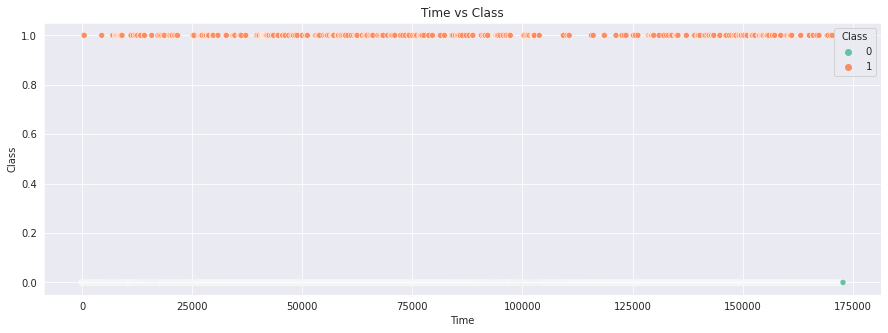

In [9]:
# Create a scatter plot to observe the distribution of classes with time
plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
sns.set_palette('Set2')
sns.scatterplot(df.Time,df.Class,hue=df.Class)
plt.title("Time vs Class")
plt.show()

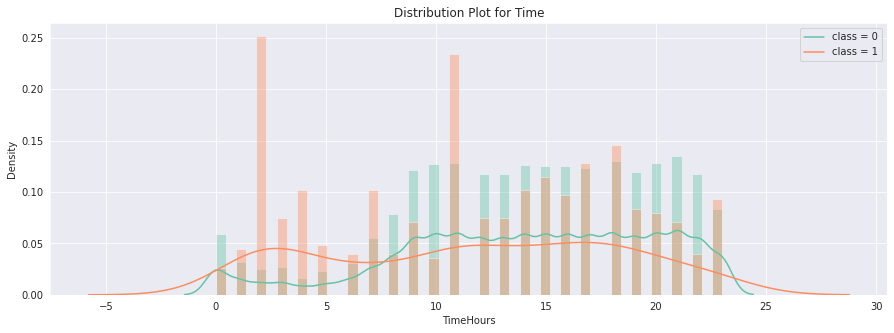

In [10]:
plt.figure(figsize=(15,5))

sns.distplot(df.TimeHours[df.Class == 0],bins=50)
sns.distplot(df.TimeHours[df.Class == 1],bins=50)
plt.title("Distribution Plot for Time")
plt.legend(labels=['class = 0','class = 1'])
plt.show()

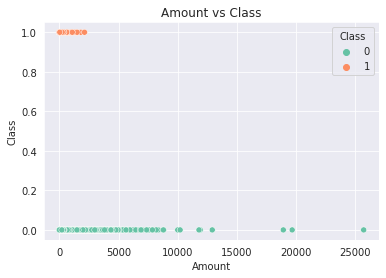

In [11]:
# Create a scatter plot to observe the distribution of classes with Amount
sns.scatterplot(df.Amount,df.Class,hue=df.Class)
plt.title("Amount vs Class")
plt.show()

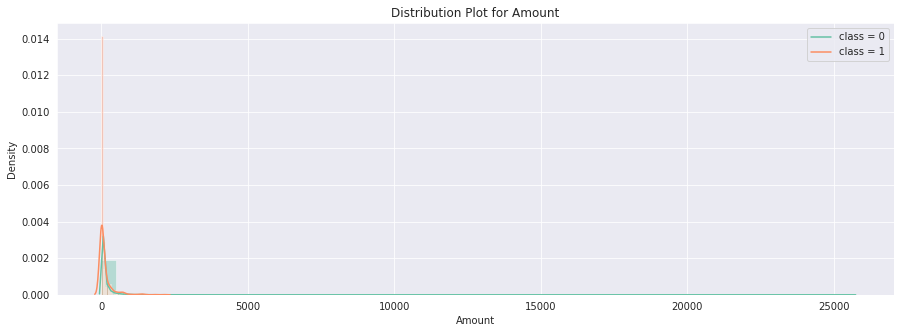

In [12]:
plt.figure(figsize=(15,5))

sns.distplot(df.Amount[df.Class == 0],bins=50)
sns.distplot(df.Amount[df.Class == 1],bins=50)
plt.title("Distribution Plot for Amount")
plt.legend(labels=['class = 0','class = 1'])
plt.show()

In [13]:
# Deriving the correlation matrix:
print("Finding the Most important features With respect to the Target: Class")

corrMatrix = pd.DataFrame(df.corr()['Class'])

# correcting the column label to "correlation"
corrMatrix.columns = ["Correlation"]
# sort correlation
corrMatrix = corrMatrix.sort_values(by=['Correlation'], ascending=False)
corrMatrix.head(10)

Finding the Most important features With respect to the Target: Class


,Correlation
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090
V8,0.019875
V27,0.017580
V28,0.009536


In [14]:
# Drop unnecessary columns
df.drop(['Time','TimeDays'],axis = 1, inplace= True)

In [15]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,TimeHours
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


### Splitting the data into train & test data

In [16]:
y= df['Class']
X= df.drop('Class',axis=1)

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.20,random_state=42)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [18]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


### Plotting the distribution of a variable

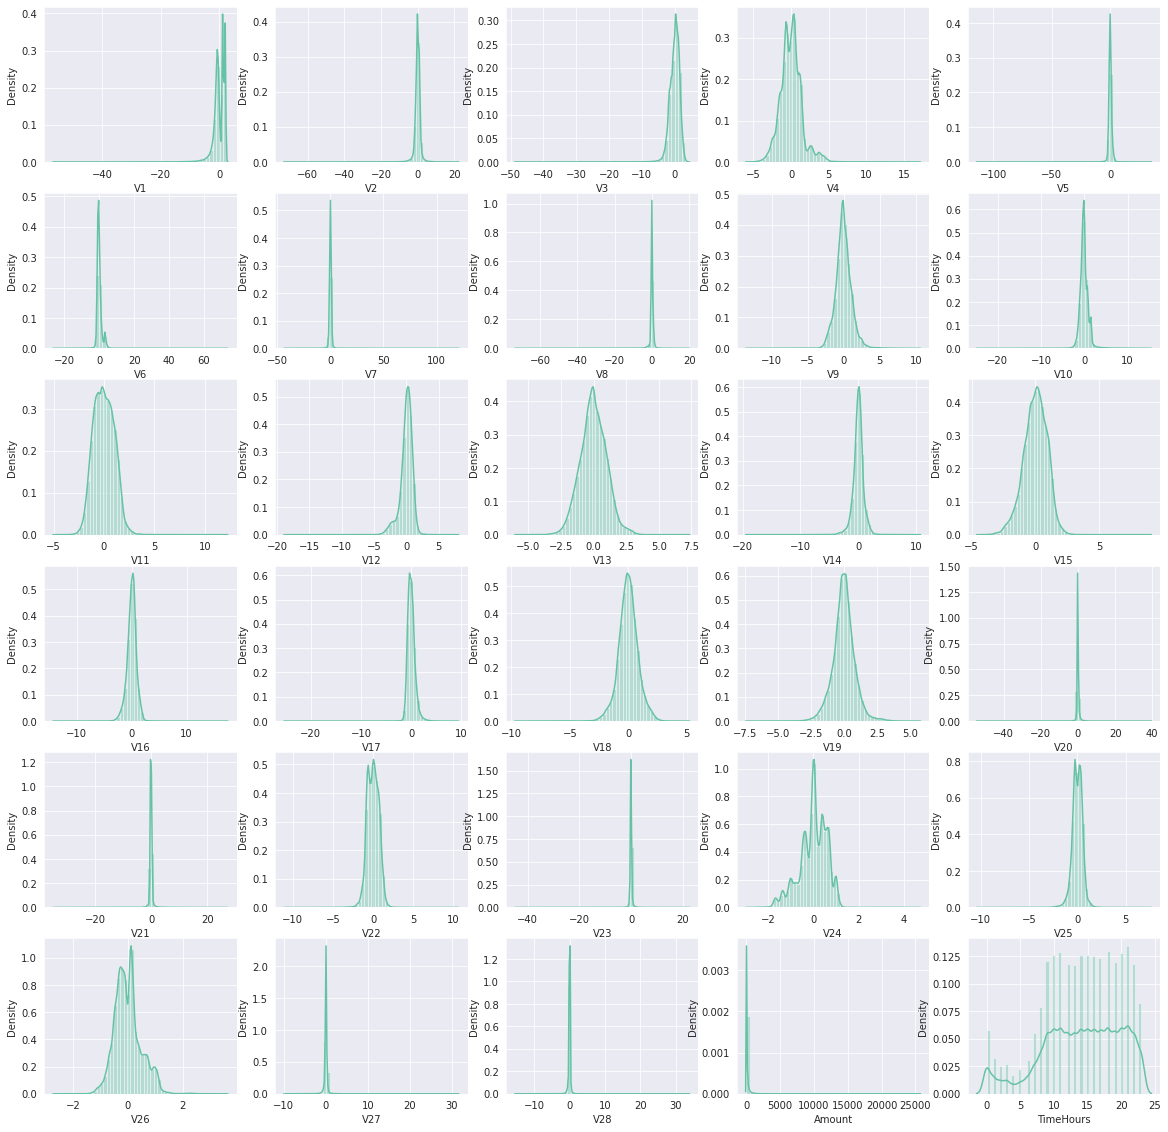

In [19]:
# plot the histogram of a variable from the dataset to see the skewness
plt.figure(figsize=(20,20))

cols = X_train.columns.values

subPlot_Rows = np.ceil(np.sqrt(len(cols)))
subPlot_Cols = np.floor(np.sqrt(len(cols)))
i=1

for col in cols:
  plt.subplot(subPlot_Rows,subPlot_Cols,i)
  sns.distplot(X_train[col])
  i+=1

In [20]:
# Lets check the skewness of the features
cols = X_train.columns.values
skew_cols = []
for i in cols:
    skew_cols.append(X_train[i].skew())

skewnessDF = pd.DataFrame({"Features":cols,"Skewness":skew_cols})
skewnessDF

,Features,Skewness
0,V1,-3.320269
1,V2,-4.826847
2,V3,-2.219375
3,V4,0.677776
4,V5,-2.928646
5,V6,1.977725
6,V7,3.744620
7,V8,-8.445014
8,V9,0.543603
9,V10,1.212102


In [21]:
#filtering columns that have a skewness of more than 1
skew_cols = list(skewnessDF[(skewnessDF.Skewness <-1) | (skewnessDF.Skewness > 1)].Features)

In [22]:
print(skew_cols)

['V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V28', 'Amount']


### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [23]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data

pt = preprocessing.PowerTransformer(copy=False)

# Fit_transform the power transformer on train data
X_train[skew_cols] = pt.fit_transform(X_train[skew_cols])

# Fit_transform the power transformer on test data
X_test[skew_cols] = pt.fit_transform(X_test[skew_cols])

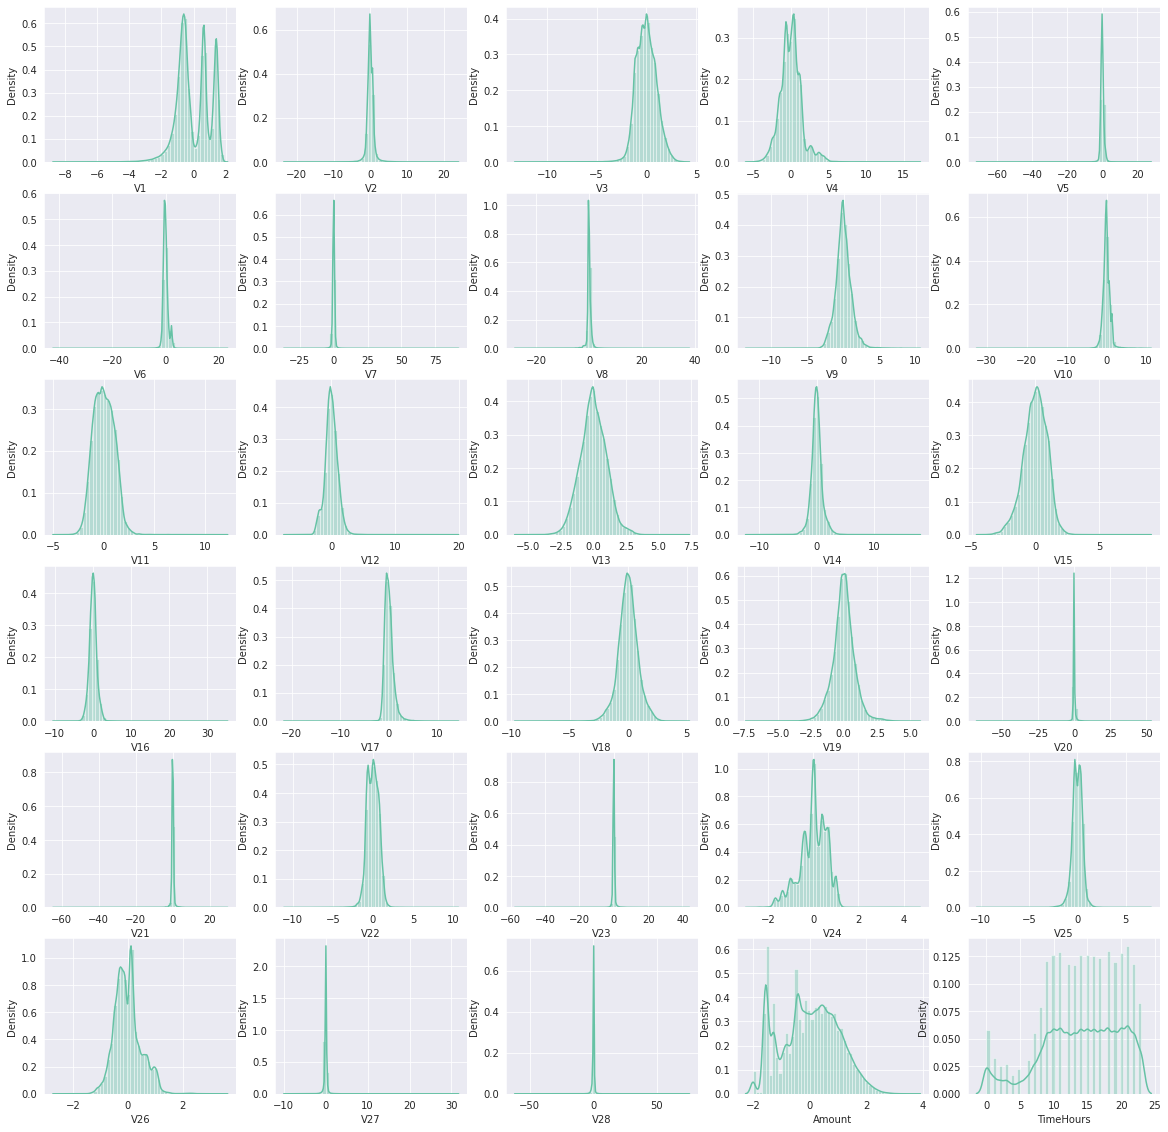

In [24]:
# plot the histogram of a variable from the dataset again to see the result 

plt.figure(figsize=(20,20))

cols = X_train.columns.values

subPlot_Rows = np.ceil(np.sqrt(len(cols)))
subPlot_Cols = np.floor(np.sqrt(len(cols)))
i=1

for col in cols:
  plt.subplot(subPlot_Rows,subPlot_Cols,i)
  sns.distplot(X_train[col])
  i+=1

## Model Building
- Build different models on the imbalanced dataset and see the result

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

###perform cross validation

###perform hyperparameter tuning

###print the evaluation result by choosing a evaluation metric

###print the optimum value of hyperparameters

In [25]:
# Calculating the ROC-AUC score, F1 score and the classification report of the produced model.
  
def performance_scores(y_test, y_pred):
    
    print("F1 Score: ",round(f1_score(y_test, y_pred)*100,2))
    print("Classification Report: \n",classification_report(y_test, y_pred))
    print("Confusion Matrix: ")
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='YlGnBu',fmt='g')
    plt.show()
    print("\n")

In [26]:
#Create a dataframe to store results
performance_data = pd.DataFrame(columns =['Dataset Type','Model Description','ROC_AUC_SCORE'])

In [27]:
# Draw ROC Curve 
def draw_roc(dataset_type,model_desc,performance_data,actual, pred_proba):
    fpr, tpr, thresholds = metrics.roc_curve( actual,
                                              pred_proba,
                                              drop_intermediate = False)
    
    auc_score = metrics.roc_auc_score(actual, pred_proba)
    performance_data = performance_data.append(pd.DataFrame({'Dataset Type':[dataset_type],'Model Description': [model_desc],'ROC_AUC_SCORE': [auc_score]}))
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC CURVE')
    plt.legend(loc="top right")
    plt.show()

    return performance_data

## **1) LOGISTIC REGRESSION**

In [28]:
# Logistic Regression

num_C = [0.01, 0.1, 1, 10, 100] #--> list of values
cv_num = 5

# Logistic Regression parameters for Stratified K-fold cross vaidation
params = {"C": num_C}
folds = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=4)


#perform cross validation
LRmodel_cv = GridSearchCV(estimator = LogisticRegression(random_state=4),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        n_jobs=-1,
                        verbose = 1,
                        return_train_score=True) 
#perform hyperparameter tuning
LRmodel_cv.fit(X_train, y_train)
#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', LRmodel_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', LRmodel_cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best ROC-AUC score:  0.979834018212347
Most Optimal hyperparameters:  {'C': 0.01}


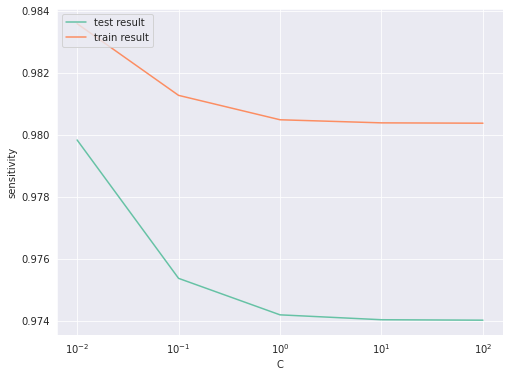

In [29]:
# cross validation results
cv_results = pd.DataFrame(LRmodel_cv.cv_results_)

# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [30]:
# Building the Logistic Regression model with best C
optimal_LRModel = LRmodel_cv.best_estimator_

# Fitting the model on train dataset
optimal_LRModel.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=4)

F1 Score:  73.76
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.90      0.62      0.74       394

    accuracy                           1.00    227845
   macro avg       0.95      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Confusion Matrix: 


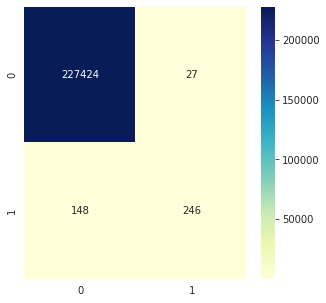

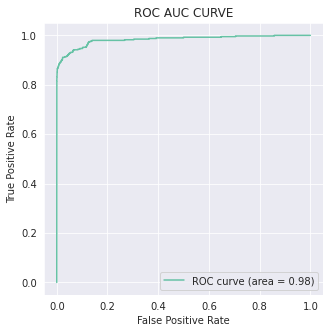

In [31]:
# Predictions on the train set
y_train_pred = optimal_LRModel.predict(X_train)
performance_scores(y_train, y_train_pred)

y_train_pred_proba = optimal_LRModel.predict_proba(X_train)[:,1]
performance_data = draw_roc("Train","Unbalanced_LR_Model",performance_data,y_train,y_train_pred_proba)

F1 Score:  69.51
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


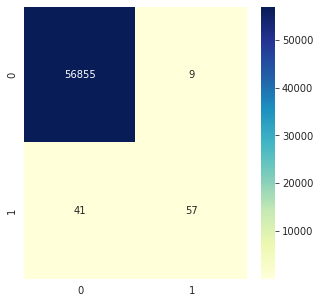

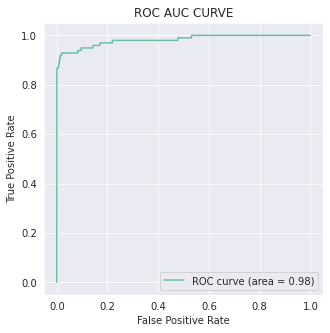

In [32]:
# Predictions on the Test set
y_test_pred = optimal_LRModel.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_LRModel.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","Unbalanced_LR_Model",performance_data,y_test,y_test_pred_proba)

In [33]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606


### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

# **2) Decision Tree**

In [34]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 20, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dt = DecisionTreeClassifier(random_state=4)

DTmodel_cv = GridSearchCV(estimator = dt, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = folds, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
DTmodel_cv.fit(X_train,y_train)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', DTmodel_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', DTmodel_cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC score:  0.9418978225203147
Most Optimal hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 50}


In [35]:
# Building the Descission Tree model with best Parameters
optimal_DTModel = DTmodel_cv.best_estimator_

# Fitting the model on train dataset
optimal_DTModel.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=50,
                       random_state=4)

F1 Score:  72.33
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.77      0.68      0.72       394

    accuracy                           1.00    227845
   macro avg       0.89      0.84      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Confusion Matrix: 


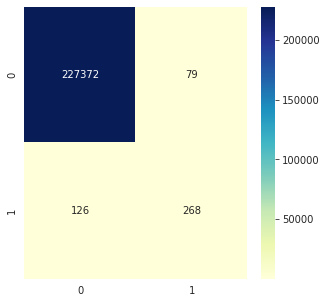

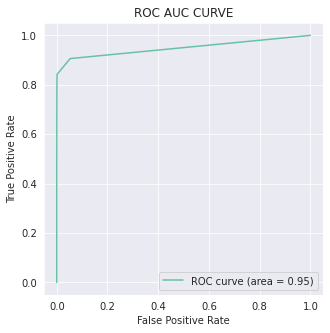

In [36]:
# Predictions on the train set
y_train_pred = optimal_DTModel.predict(X_train)
performance_scores(y_train, y_train_pred)

y_train_pred_proba = optimal_DTModel.predict_proba(X_train)[:,1]
performance_data = draw_roc("Train","Unbalanced_DT_Model",performance_data,y_train,y_train_pred_proba)

F1 Score:  72.45
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.72      0.72        98

    accuracy                           1.00     56962
   macro avg       0.86      0.86      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


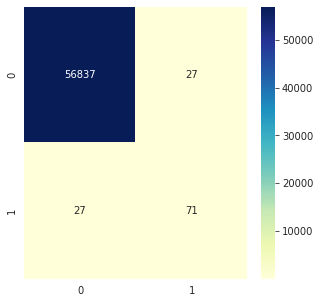

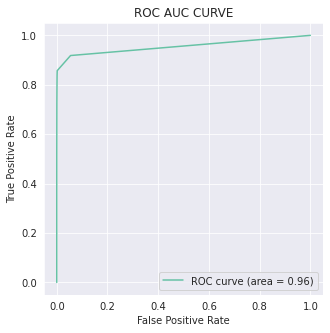

In [37]:
# Predictions on the Test set
y_test_pred = optimal_DTModel.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_DTModel.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","Unbalanced_DT_Model",performance_data,y_test,y_test_pred_proba)

In [38]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038


# **3) XGBOOST**

In [39]:
# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200,random_state=4)

# set up GridSearchCV()
XGBmodel_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
XGBmodel_cv.fit(X_train, y_train)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', XGBmodel_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', XGBmodel_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best ROC-AUC score:  0.9793606948144987
Most Optimal hyperparameters:  {'learning_rate': 0.2, 'subsample': 0.9}


In [40]:
# Building the XGBoost model with best Parameters
optimal_XGBmodel = XGBmodel_cv.best_estimator_

# Fitting the model on train dataset
optimal_XGBmodel.fit(X_train, y_train)

XGBClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, random_state=4,
              subsample=0.9)

F1 Score:  91.7
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.99      0.86      0.92       394

    accuracy                           1.00    227845
   macro avg       0.99      0.93      0.96    227845
weighted avg       1.00      1.00      1.00    227845

Confusion Matrix: 


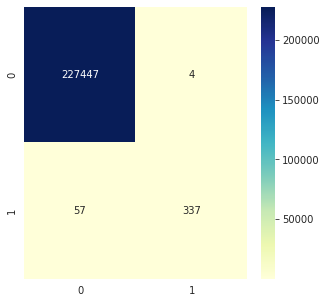

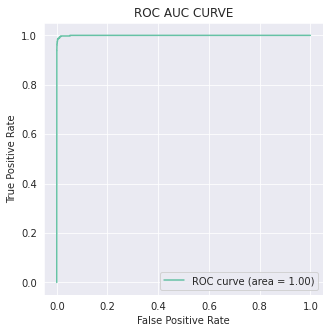

In [41]:
# Predictions on the train set
y_train_pred = optimal_XGBmodel.predict(X_train)
performance_scores(y_train, y_train_pred)

y_train_pred_proba = optimal_XGBmodel.predict_proba(X_train)[:,1]
performance_data = draw_roc("Train","Unbalanced_XGB_Model",performance_data,y_train,y_train_pred_proba)

F1 Score:  88.76
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.81      0.89        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


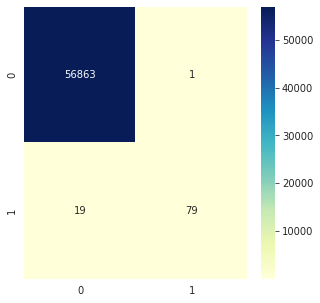

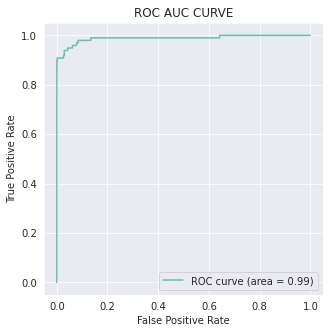

In [42]:
# Predictions on the Test set
y_test_pred = optimal_XGBmodel.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_XGBmodel.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","Unbalanced_XGB_Model",performance_data,y_test,y_test_pred_proba)

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [43]:
performance_data[performance_data['Dataset Type']=='Test']

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Test,Unbalanced_LR_Model,0.981606
0,Test,Unbalanced_DT_Model,0.955038
0,Test,Unbalanced_XGB_Model,0.988414


## **UNBALANCED DATA**

---

#### **As we can see from the above table XGBoost model gives us the best result out of the 3 models tested on unbalanced data .**

#### **ROC-AUC score on the train data is 99.96% and on test data 98.84%**

F1 Score:  88.76
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.81      0.89        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


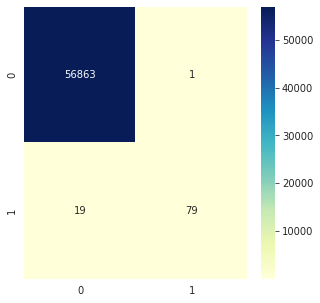

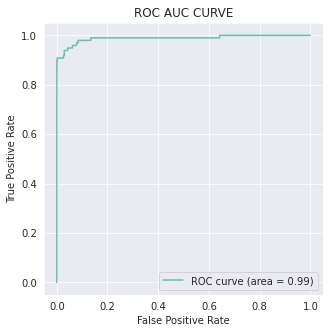

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Test,Unbalanced_XGB_Model,0.988414
0,Test,Unbalanced_XGB_Model,0.988414


In [44]:
''' Predictions on the Test set using the BEST MODEL - XGBOOST 
with the optimal parameters - XGBClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, subsample=0.6) '''

y_test_pred = optimal_XGBmodel.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_XGBmodel.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","Unbalanced_XGB_Model",performance_data,y_test,y_test_pred_proba)
performance_data[(performance_data['Model Description'] == 'Unbalanced_XGB_Model') & (performance_data['Dataset Type'] == 'Test')]

In [45]:
performance_data.drop_duplicates(inplace=True)

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 17
2nd Top var = 14
3rd Top var = 10


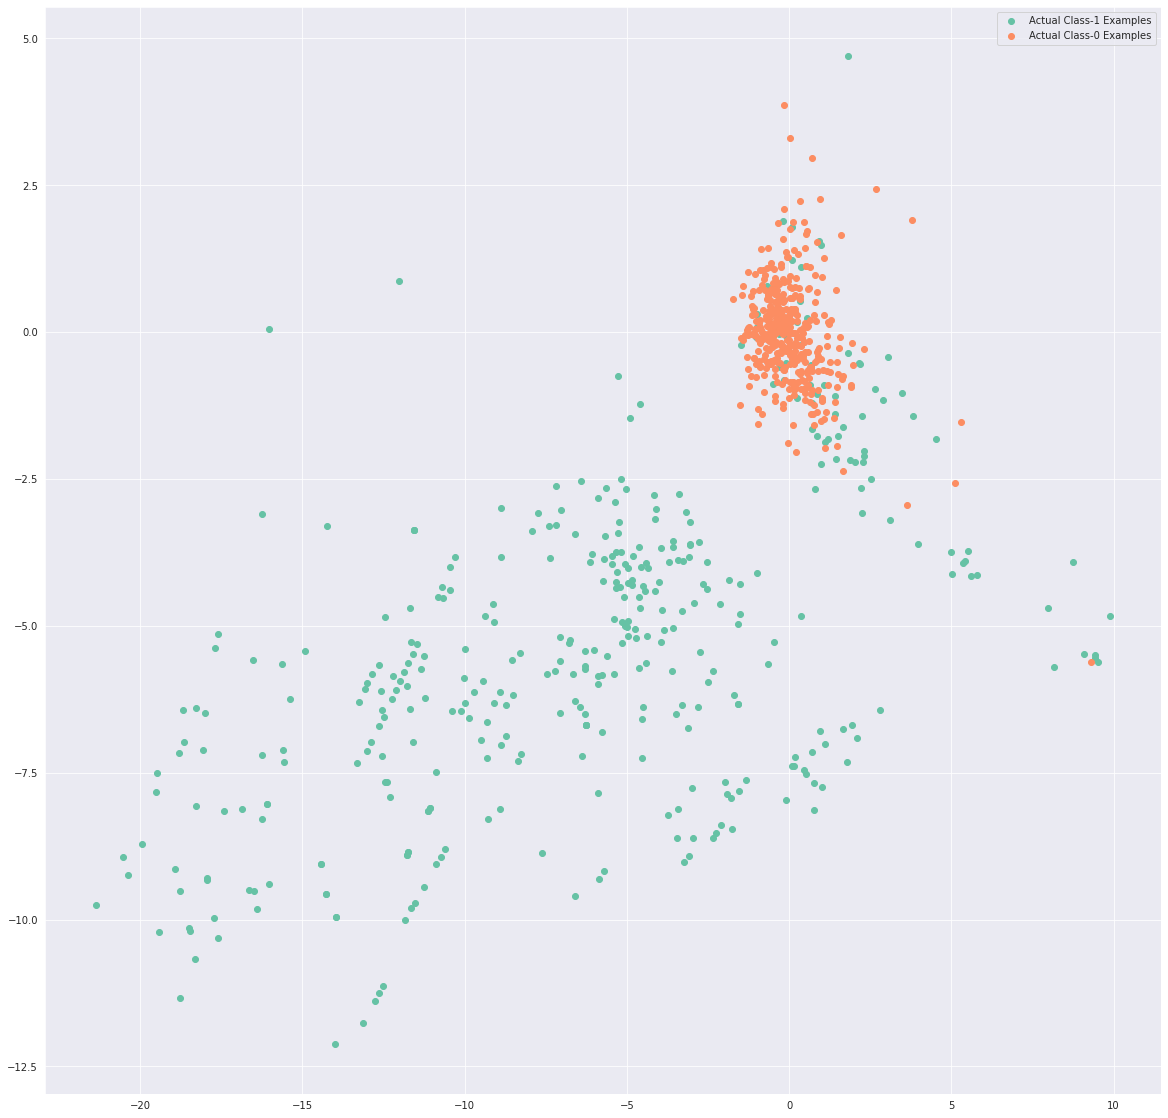

In [46]:
var_imp = []
for i in optimal_XGBmodel.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(optimal_XGBmodel.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(optimal_XGBmodel.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(optimal_XGBmodel.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(optimal_XGBmodel.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(optimal_XGBmodel.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

# **BALANCING DATASET CLASSES USING THE ABOVE METHODS**

# **1) Random OverSampling**

In [47]:
#- import the packages
# Importing oversampler library
from imblearn.over_sampling import RandomOverSampler

In [48]:
# instantiating the random oversampler 
ros = RandomOverSampler(random_state=4)

# resampling X_train and y_train
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [49]:
#Class distribution before sampling 
print('Before sampling class distribution:\n',y_train.value_counts())
#Class distribution after OverSampling 
print('New class distribution:\n',y_train_ros.value_counts())

Before sampling class distribution:
 0    227451
1       394
Name: Class, dtype: int64
New class distribution:
 0    227451
1    227451
Name: Class, dtype: int64


#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [50]:
# Logistic Regression on Balanced Dataset

num_C = [0.01, 0.1, 1, 10, 100] #--> list of values
cv_num = 5

# Logistic Regression parameters for Stratified K-fold cross vaidation
params = {"C": num_C}
folds = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=4)


#perform cross validation
LRmodel_balanced_cv = GridSearchCV(estimator = LogisticRegression(random_state=4),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds,
                        verbose = 1,
                        return_train_score=True) 
#perform hyperparameter tuning
LRmodel_balanced_cv.fit(X_train_ros, y_train_ros)
#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', LRmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', LRmodel_balanced_cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best ROC-AUC score:  0.987411272936354
Most Optimal hyperparameters:  {'C': 10}


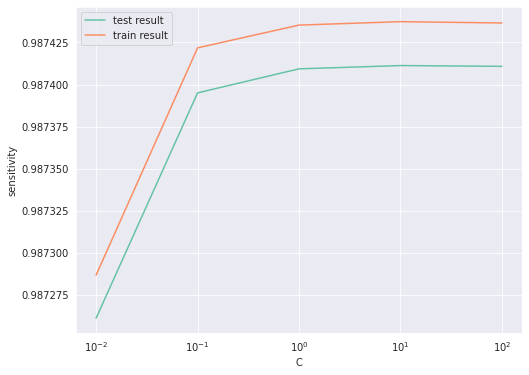

In [51]:
# cross validation results
cv_results = pd.DataFrame(LRmodel_balanced_cv.cv_results_)

# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [52]:
# Building the Logistic Regression model with best C
optimal_LRModel_balanced_ros = LRmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_LRModel_balanced_ros.fit(X_train_ros, y_train_ros)

LogisticRegression(C=10, random_state=4)

F1 Score:  94.35
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    227451
           1       0.97      0.92      0.94    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.94    454902
weighted avg       0.95      0.95      0.94    454902

Confusion Matrix: 


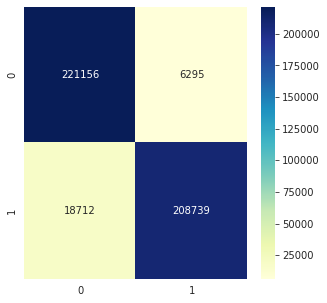

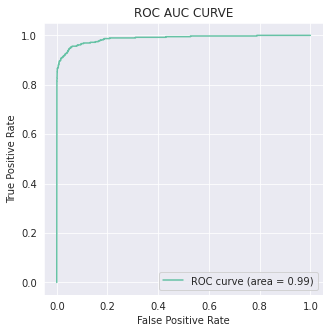

In [53]:
# Predictions on the train set
y_train_pred = optimal_LRModel_balanced_ros.predict(X_train_ros)
performance_scores(y_train_ros, y_train_pred)

y_train_pred_proba = optimal_LRModel_balanced_ros.predict_proba(X_train_ros)[:,1]
performance_data = draw_roc("Train","ROS_balanced_LR_Model",performance_data,y_train_ros,y_train_pred_proba)

F1 Score:  9.89
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Confusion Matrix: 


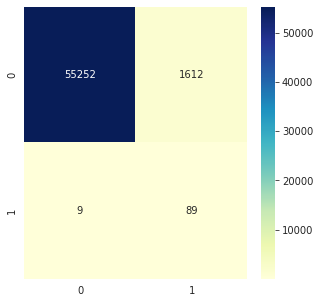

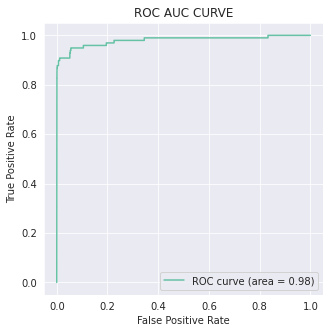

In [54]:
# Predictions on the Test set
y_test_pred = optimal_LRModel_balanced_ros.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_LRModel_balanced_ros.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","ROS_balanced_LR_Model",performance_data,y_test,y_test_pred_proba)

In [55]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038
0,Train,Unbalanced_XGB_Model,0.999660
0,Test,Unbalanced_XGB_Model,0.988414
0,Train,ROS_balanced_LR_Model,0.987434
0,Test,ROS_balanced_LR_Model,0.980023


### Similarly explore other algorithms on balanced dataset by building models like:
- Logistic Regression
- Decision Tree
- XGBoost

## **2) Decision Tree**

In [56]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 20, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dt = DecisionTreeClassifier(random_state=4)

DTmodel_balanced_cv = GridSearchCV(estimator = dt, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = folds, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
DTmodel_balanced_cv.fit(X_train_ros,y_train_ros)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', DTmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', DTmodel_balanced_cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC score:  0.999733627841929
Most Optimal hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 50, 'min_samples_split': 50}


In [57]:
# Building the Descission Tree model with best Parameters
optimal_DTModel_balanced_ros = DTmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_DTModel_balanced_ros.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=50, min_samples_split=50,
                       random_state=4)

F1 Score:  99.85
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Confusion Matrix: 


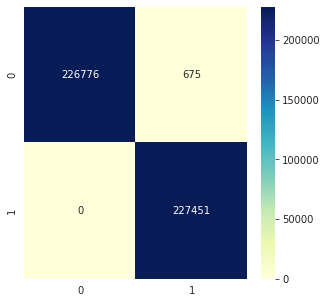

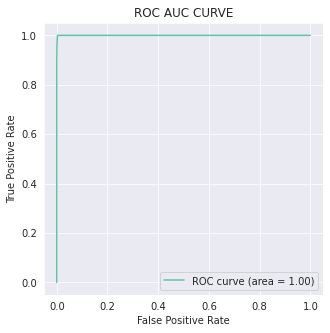

In [58]:
# Predictions on the train set
y_train_pred = optimal_DTModel_balanced_ros.predict(X_train_ros)
performance_scores(y_train_ros, y_train_pred)

y_train_pred_proba = optimal_DTModel_balanced_ros.predict_proba(X_train_ros)[:,1]
performance_data = draw_roc("Train","ROS_balanced_DT_Model",performance_data,y_train_ros,y_train_pred_proba)

F1 Score:  43.14
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.79      0.43        98

    accuracy                           1.00     56962
   macro avg       0.65      0.89      0.71     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


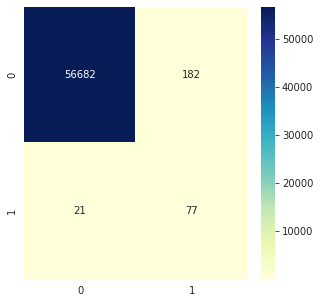

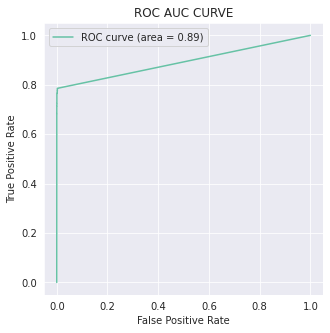

In [59]:
# Predictions on the Test set
y_test_pred = optimal_DTModel_balanced_ros.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_DTModel_balanced_ros.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","ROS_balanced_DT_Model",performance_data,y_test,y_test_pred_proba)

In [60]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038
0,Train,Unbalanced_XGB_Model,0.999660
0,Test,Unbalanced_XGB_Model,0.988414
0,Train,ROS_balanced_LR_Model,0.987434
0,Test,ROS_balanced_LR_Model,0.980023
0,Train,ROS_balanced_DT_Model,0.999897
0,Test,ROS_balanced_DT_Model,0.892339


In [61]:
# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
XGBmodel_balanced_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
XGBmodel_balanced_cv.fit(X_train_ros, y_train_ros)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', XGBmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', XGBmodel_balanced_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best ROC-AUC score:  0.9999833931127027
Most Optimal hyperparameters:  {'learning_rate': 0.6, 'subsample': 0.9}


In [62]:
# Building the XGBoost model with best Parameters
optimal_XGBmodel_balanced_ros = XGBmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_XGBmodel_balanced_ros.fit(X_train_ros, y_train_ros)

XGBClassifier(learning_rate=0.6, max_depth=2, n_estimators=200, subsample=0.9)

F1 Score:  99.99
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Confusion Matrix: 


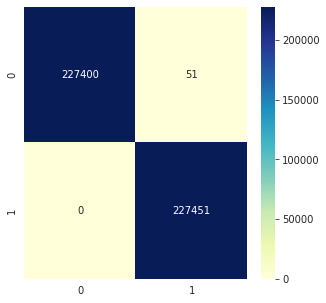

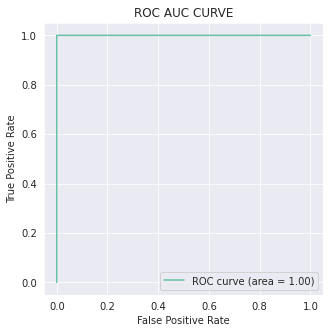

In [63]:
# Predictions on the train set
y_train_pred = optimal_XGBmodel_balanced_ros.predict(X_train_ros)
performance_scores(y_train_ros, y_train_pred)

y_train_pred_proba = optimal_XGBmodel_balanced_ros.predict_proba(X_train_ros)[:,1]
performance_data = draw_roc("Train","ROS_balanced_XGB_Model",performance_data,y_train_ros,y_train_pred_proba)

F1 Score:  81.55
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.86      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


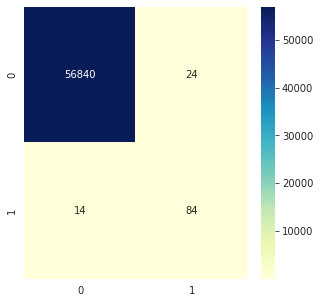

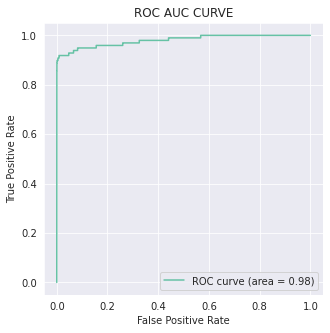

In [64]:
# Predictions on the Test set
y_test_pred = optimal_XGBmodel_balanced_ros.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_XGBmodel_balanced_ros.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","ROS_balanced_XGB_Model",performance_data,y_test,y_test_pred_proba)

In [65]:
performance_data[performance_data['Dataset Type']=='Test']

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Test,Unbalanced_LR_Model,0.981606
0,Test,Unbalanced_DT_Model,0.955038
0,Test,Unbalanced_XGB_Model,0.988414
0,Test,ROS_balanced_LR_Model,0.980023
0,Test,ROS_balanced_DT_Model,0.892339
0,Test,ROS_balanced_XGB_Model,0.979970


## **RANDOM OVER SAMPLING(ROS) BALANCED DATA**

---

#### **As we can see from the above table Logistic Regression model gives us the best result out of the 3 models tested on ROS balanced data .**

#### **ROC-AUC score on the train data is 98.73% and on test data 98.00%**

# **2)SMOTE**

### Print the class distribution after applying SMOTE 

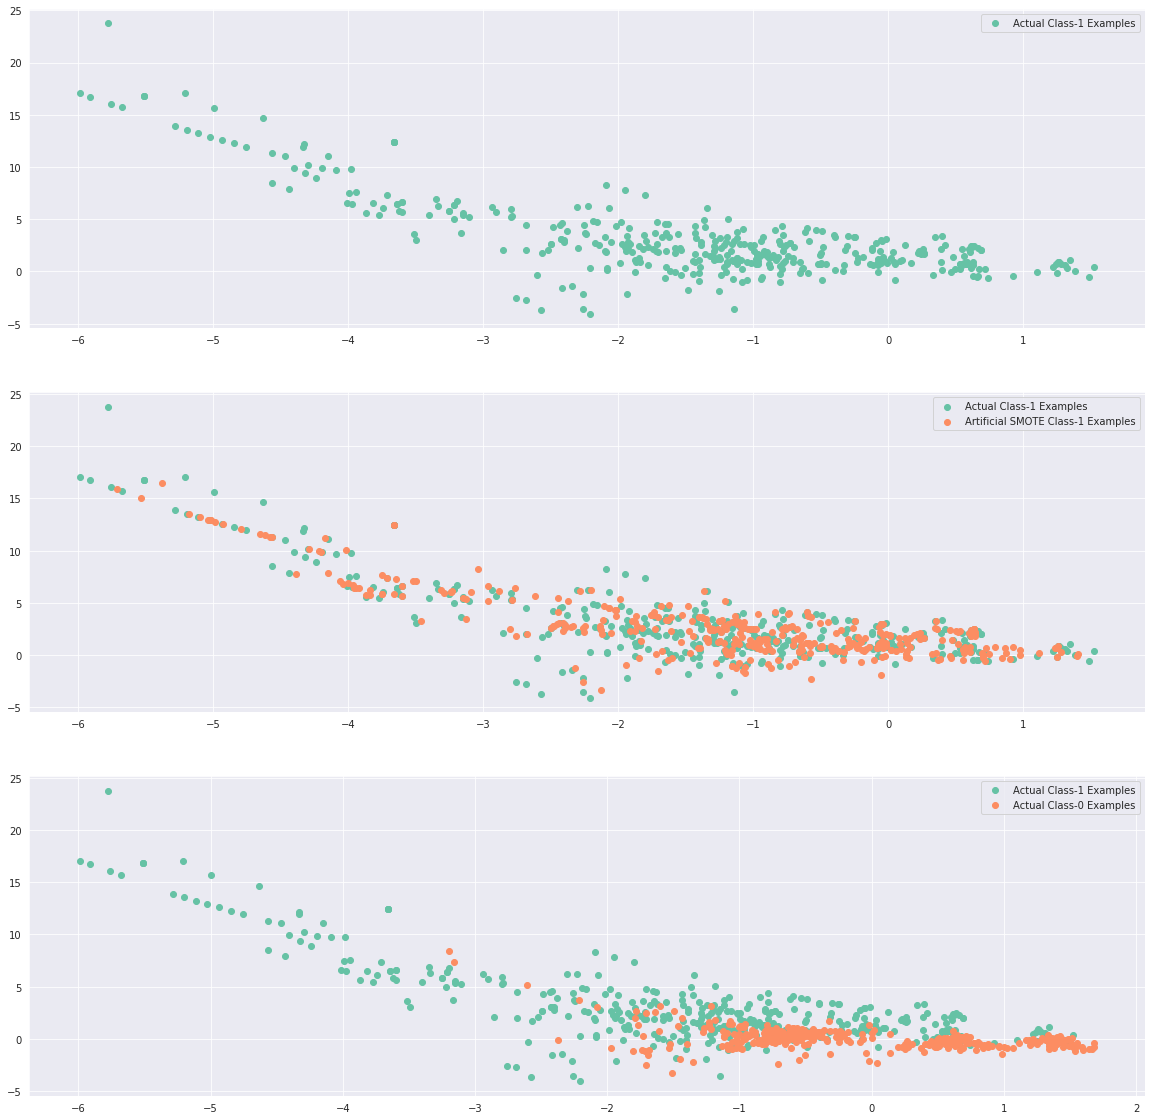

In [68]:
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=4)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], X_train_smote_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [69]:
#Class distribution before sampling 
print('Before sampling class distribution:\n',y_train.value_counts())
#Class distribution after OverSampling 
print('New class distribution:\n',y_train_smote.value_counts())

Before sampling class distribution:
 0    227451
1       394
Name: Class, dtype: int64
New class distribution:
 0    227451
1    227451
Name: Class, dtype: int64


In [70]:
# Logistic Regression on Balanced Dataset

num_C = [0.01, 0.1, 1, 10, 100] #--> list of values
cv_num = 5

# Logistic Regression parameters for Stratified K-fold cross vaidation
params = {"C": num_C}
folds = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=4)


#perform cross validation
LRmodel_balanced_cv = GridSearchCV(estimator = LogisticRegression(random_state=4),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds,
                        verbose = 1,
                        return_train_score=True) 
#perform hyperparameter tuning
LRmodel_balanced_cv.fit(X_train_smote, y_train_smote)
#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', LRmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', LRmodel_balanced_cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best ROC-AUC score:  0.9896971737022617
Most Optimal hyperparameters:  {'C': 100}


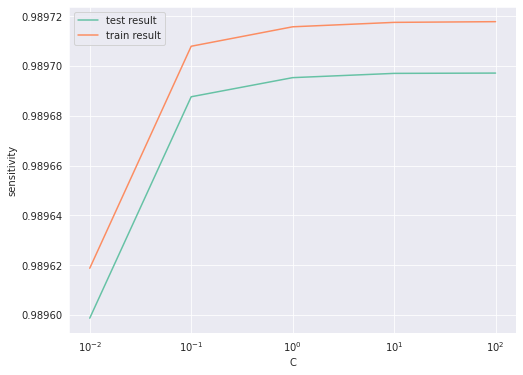

In [71]:
# cross validation results
cv_results = pd.DataFrame(LRmodel_balanced_cv.cv_results_)

# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [72]:
# Building the Logistic Regression model with best C
optimal_LRModel_balanced_smote = LRmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_LRModel_balanced_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(C=100, random_state=4)

F1 Score:  94.38
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    227451
           1       0.97      0.92      0.94    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

Confusion Matrix: 


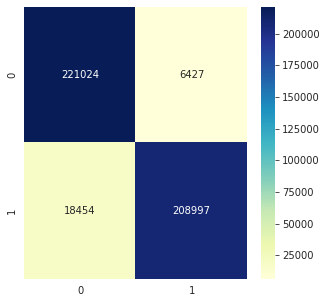

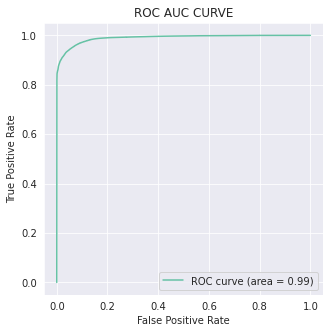

In [73]:
# Predictions on the train set
y_train_pred = optimal_LRModel_balanced_smote.predict(X_train_smote)
performance_scores(y_train_smote, y_train_pred)

y_train_pred_proba = optimal_LRModel_balanced_smote.predict_proba(X_train_smote)[:,1]
performance_data = draw_roc("Train","SMOTE_balanced_LR_Model",performance_data,y_train_smote,y_train_pred_proba)

F1 Score:  9.57
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Confusion Matrix: 


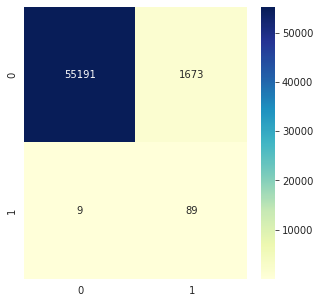

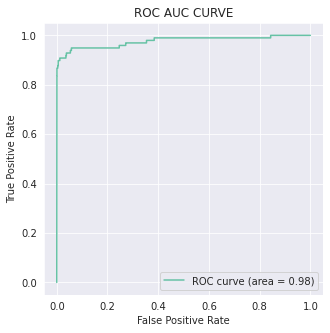

In [74]:
# Predictions on the Test set
y_test_pred = optimal_LRModel_balanced_smote.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_LRModel_balanced_smote.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","SMOTE_balanced_LR_Model",performance_data,y_test,y_test_pred_proba)

In [75]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038
0,Train,Unbalanced_XGB_Model,0.999660
0,Test,Unbalanced_XGB_Model,0.988414
0,Train,ROS_balanced_LR_Model,0.987434
0,Test,ROS_balanced_LR_Model,0.980023
0,Train,ROS_balanced_DT_Model,0.999897
0,Test,ROS_balanced_DT_Model,0.892339


##### Build models on other algorithms to see the better performing on SMOTE

## **2.2) Decision Tree**

In [76]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 20, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dt = DecisionTreeClassifier(random_state=4)

DTmodel_balanced_cv = GridSearchCV(estimator = dt, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = folds, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
DTmodel_balanced_cv.fit(X_train_smote,y_train_smote)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', DTmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', DTmodel_balanced_cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC score:  0.9989124352323296
Most Optimal hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 50, 'min_samples_split': 50}


In [77]:
# Building the Descission Tree model with best Parameters
optimal_DTModel_balanced_smote = DTmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_DTModel_balanced_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=50, min_samples_split=50,
                       random_state=4)

F1 Score:  99.25
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    227451
           1       0.99      0.99      0.99    227451

    accuracy                           0.99    454902
   macro avg       0.99      0.99      0.99    454902
weighted avg       0.99      0.99      0.99    454902

Confusion Matrix: 


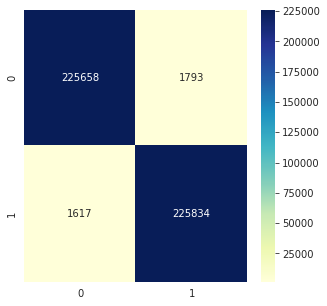

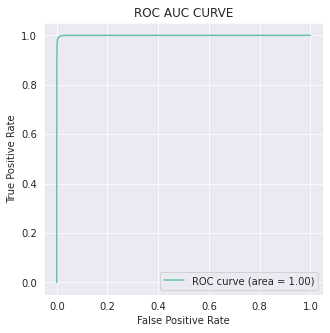

In [78]:
# Predictions on the train set
y_train_pred = optimal_DTModel_balanced_smote.predict(X_train_smote)
performance_scores(y_train_smote, y_train_pred)

y_train_pred_proba = optimal_DTModel_balanced_smote.predict_proba(X_train_smote)[:,1]
performance_data = draw_roc("Train","SMOTE_balanced_DT_Model",performance_data,y_train_smote,y_train_pred_proba)

F1 Score:  24.13
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.85      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.92      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix: 


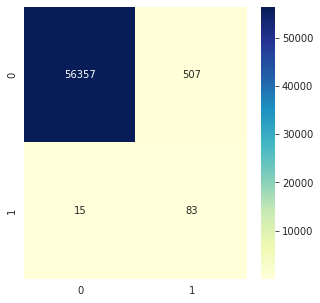

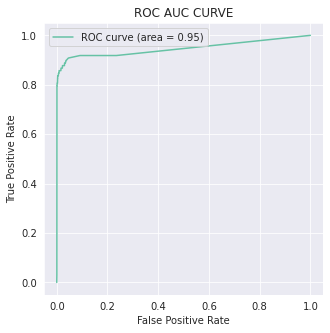

In [79]:
# Predictions on the Test set
y_test_pred = optimal_DTModel_balanced_smote.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_DTModel_balanced_smote.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","SMOTE_balanced_DT_Model",performance_data,y_test,y_test_pred_proba)

In [80]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038
0,Train,Unbalanced_XGB_Model,0.999660
0,Test,Unbalanced_XGB_Model,0.988414
0,Train,ROS_balanced_LR_Model,0.987434
0,Test,ROS_balanced_LR_Model,0.980023
0,Train,ROS_balanced_DT_Model,0.999897
0,Test,ROS_balanced_DT_Model,0.892339


### **2.3) XG BOOST**

In [81]:
# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200,random_state=4)

# set up GridSearchCV()
XGBmodel_balanced_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
XGBmodel_balanced_cv.fit(X_train_smote, y_train_smote)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', XGBmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', XGBmodel_balanced_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best ROC-AUC score:  0.999945131976315
Most Optimal hyperparameters:  {'learning_rate': 0.6, 'subsample': 0.6}


In [82]:
# Building the XGBoost model with best Parameters
optimal_XGBmodel_balanced_smote = XGBmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_XGBmodel_balanced_smote.fit(X_train_smote, y_train_smote)

XGBClassifier(learning_rate=0.6, max_depth=2, n_estimators=200, random_state=4,
              subsample=0.6)

F1 Score:  99.9
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Confusion Matrix: 


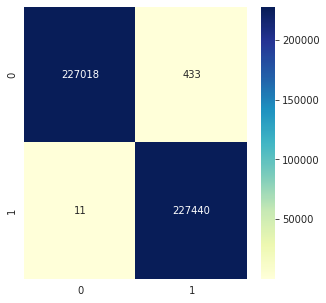

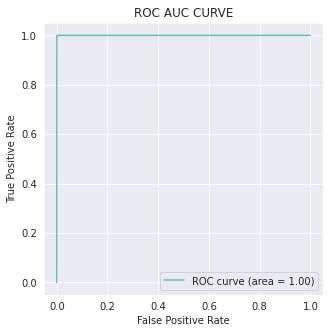

In [83]:
# Predictions on the train set
y_train_pred = optimal_XGBmodel_balanced_smote.predict(X_train_smote)
performance_scores(y_train_smote, y_train_pred)

y_train_pred_proba = optimal_XGBmodel_balanced_smote.predict_proba(X_train_smote)[:,1]
performance_data = draw_roc("Train","SMOTE_balanced_XGB_Model",performance_data,y_train_smote,y_train_pred_proba)

F1 Score:  53.42
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.88      0.53        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.77     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


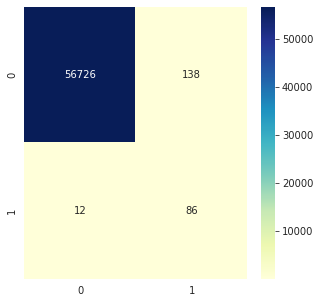

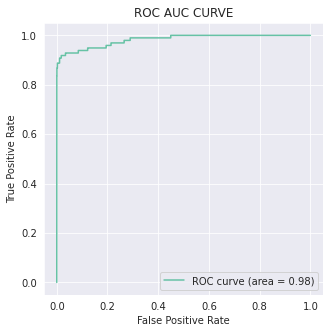

In [84]:
# Predictions on the Test set
y_test_pred = optimal_XGBmodel_balanced_smote.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_XGBmodel_balanced_smote.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","SMOTE_balanced_XGB_Model",performance_data,y_test,y_test_pred_proba)

In [85]:
performance_data[performance_data['Dataset Type']=='Test']

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Test,Unbalanced_LR_Model,0.981606
0,Test,Unbalanced_DT_Model,0.955038
0,Test,Unbalanced_XGB_Model,0.988414
0,Test,ROS_balanced_LR_Model,0.980023
0,Test,ROS_balanced_DT_Model,0.892339
0,Test,ROS_balanced_XGB_Model,0.979970
0,Test,SMOTE_balanced_LR_Model,0.976262
0,Test,SMOTE_balanced_DT_Model,0.946680
0,Test,SMOTE_balanced_XGB_Model,0.982618


### **SMOTE BALANCED DATA**

---

#### As we can see from the above table **XG Boost model gives us the best result** out of the 3 models tested on SMOTE balanced data .

#### **ROC-AUC score on the train data is 99.99% and on test data 98.26%**

### Print the class distribution after applying ADASYN

# **3)ADASYN**

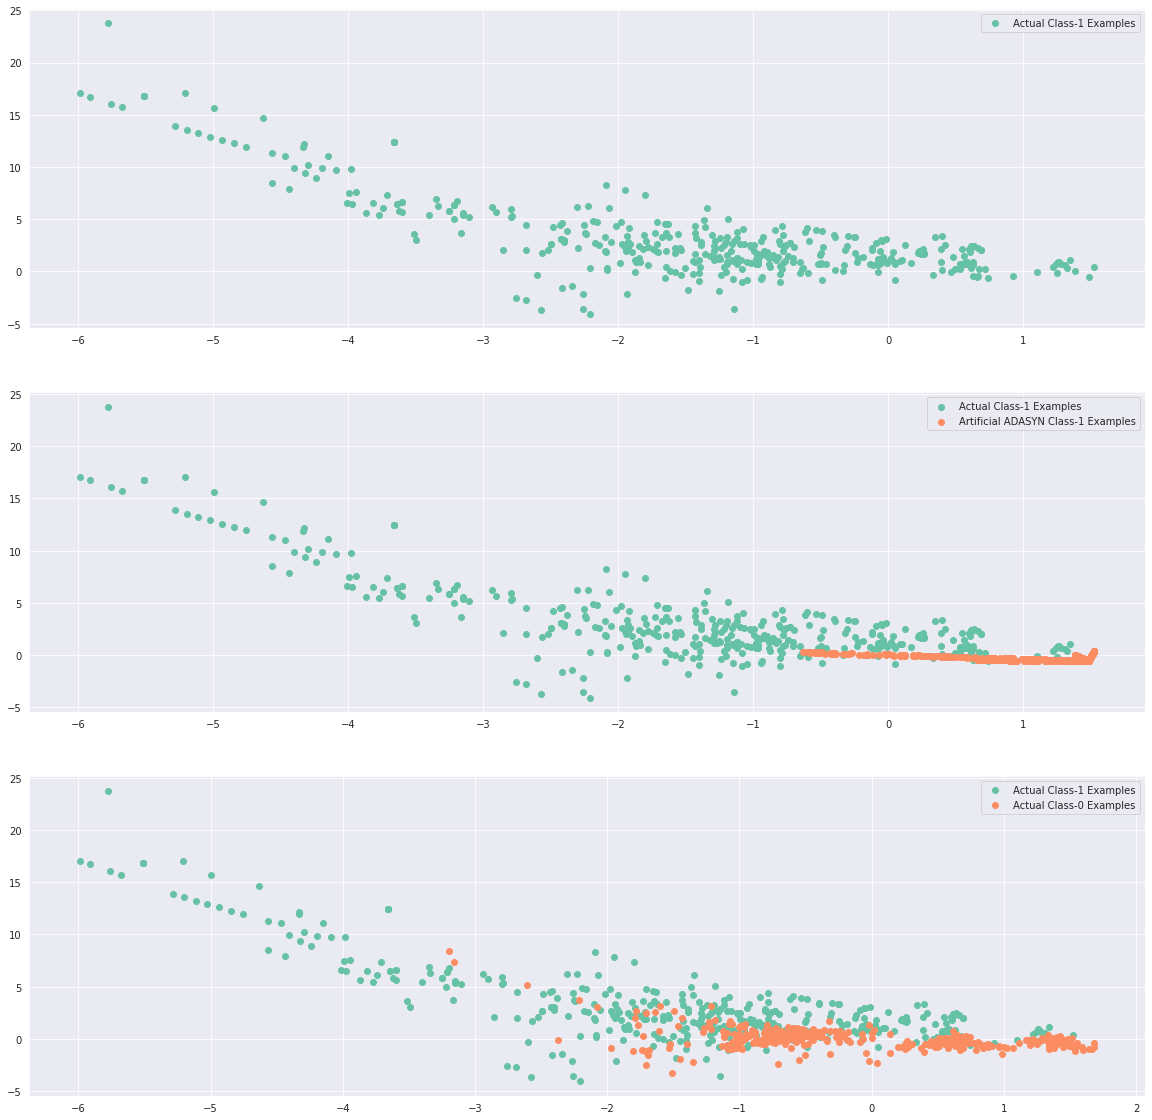

In [86]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=4)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1.iloc[:X_train_1.shape[0], 0], X_train_adasyn_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [88]:
#Class distribution before sampling 
print('Before sampling class distribution:\n',y_train.value_counts())
#Class distribution after OverSampling 
print('New class distribution:\n',y_train_adasyn.value_counts())

Before sampling class distribution:
 0    227451
1       394
Name: Class, dtype: int64
New class distribution:
 0    227451
1    227448
Name: Class, dtype: int64


##### Build models on other algorithms to see the better performing on ADASYN

In [89]:
# Logistic Regression on Balanced Dataset

num_C = [0.01, 0.1, 1, 10, 100] #--> list of values
cv_num = 5

# Logistic Regression parameters for Stratified K-fold cross vaidation
params = {"C": num_C}
folds = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=4)


#perform cross validation
LRmodel_balanced_cv = GridSearchCV(estimator = LogisticRegression(random_state=4),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds,
                        verbose = 1,
                        return_train_score=True) 
#perform hyperparameter tuning
LRmodel_balanced_cv.fit(X_train_adasyn, y_train_adasyn)
#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', LRmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', LRmodel_balanced_cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best ROC-AUC score:  0.9664539355223812
Most Optimal hyperparameters:  {'C': 10}


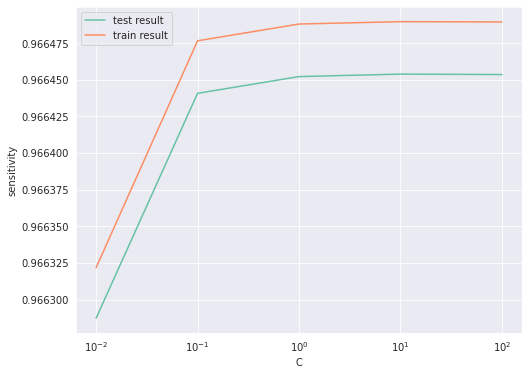

In [90]:
# cross validation results
cv_results = pd.DataFrame(LRmodel_balanced_cv.cv_results_)

# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [91]:
# Building the Logistic Regression model with best C
optimal_LRModel_balanced_adasyn = LRmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_LRModel_balanced_adasyn.fit(X_train_adasyn, y_train_adasyn)

LogisticRegression(C=10, random_state=4)

F1 Score:  89.97
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.91      0.90    227451
           1       0.91      0.89      0.90    227448

    accuracy                           0.90    454899
   macro avg       0.90      0.90      0.90    454899
weighted avg       0.90      0.90      0.90    454899

Confusion Matrix: 


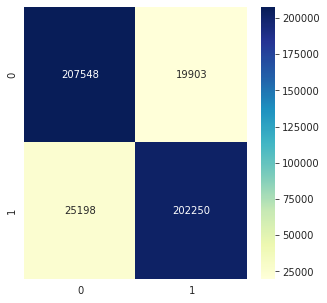

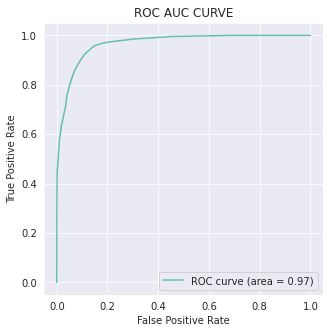

In [92]:
# Predictions on the train set
y_train_pred = optimal_LRModel_balanced_adasyn.predict(X_train_adasyn)
performance_scores(y_train_adasyn, y_train_pred)

y_train_pred_proba = optimal_LRModel_balanced_adasyn.predict_proba(X_train_adasyn)[:,1]
performance_data = draw_roc("Train","ADASYN_balanced_LR_Model",performance_data,y_train_adasyn,y_train_pred_proba)

F1 Score:  3.54
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.95      0.04        98

    accuracy                           0.91     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.91      0.95     56962

Confusion Matrix: 


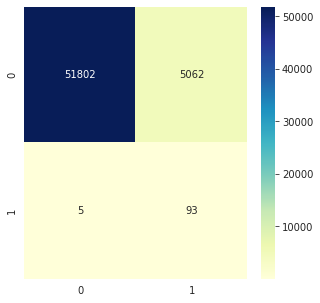

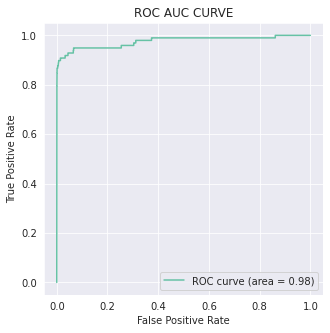

In [93]:
# Predictions on the Test set
y_test_pred = optimal_LRModel_balanced_adasyn.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_LRModel_balanced_adasyn.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","ADASYN_balanced_LR_Model",performance_data,y_test,y_test_pred_proba)

In [94]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038
0,Train,Unbalanced_XGB_Model,0.999660
0,Test,Unbalanced_XGB_Model,0.988414
0,Train,ROS_balanced_LR_Model,0.987434
0,Test,ROS_balanced_LR_Model,0.980023
0,Train,ROS_balanced_DT_Model,0.999897
0,Test,ROS_balanced_DT_Model,0.892339


## **3.2)DECISION TREE**

In [95]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 20, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dt = DecisionTreeClassifier(random_state=4)

DTmodel_balanced_cv = GridSearchCV(estimator = dt, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = folds, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
DTmodel_balanced_cv.fit(X_train_adasyn,y_train_adasyn)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', DTmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', DTmodel_balanced_cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC score:  0.9963836724101182
Most Optimal hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 50}


In [96]:
# Building the Descission Tree model with best Parameters
optimal_DTModel_balanced_adasyn = DTmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_DTModel_balanced_smote.fit(X_train_adasyn, y_train_adasyn)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=50, min_samples_split=50,
                       random_state=4)

F1 Score:  98.46
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    227451
           1       0.98      0.99      0.98    227448

    accuracy                           0.98    454899
   macro avg       0.98      0.98      0.98    454899
weighted avg       0.98      0.98      0.98    454899

Confusion Matrix: 


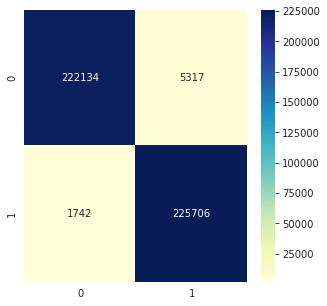

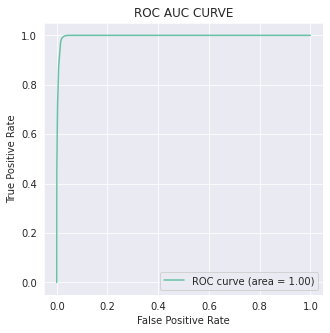

In [97]:
# Predictions on the train set
y_train_pred = optimal_DTModel_balanced_adasyn.predict(X_train_adasyn)
performance_scores(y_train_adasyn, y_train_pred)

y_train_pred_proba = optimal_DTModel_balanced_adasyn.predict_proba(X_train_adasyn)[:,1]
performance_data = draw_roc("Train","ADASYN_balanced_DT_Model",performance_data,y_train_adasyn,y_train_pred_proba)

F1 Score:  11.36
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix: 


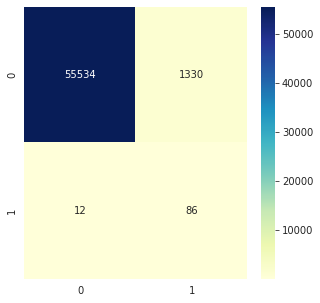

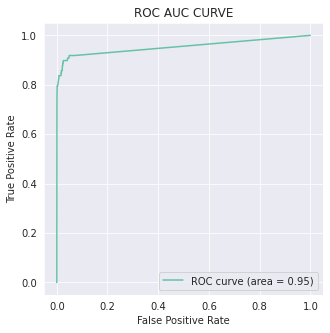

In [98]:
# Predictions on the Test set
y_test_pred = optimal_DTModel_balanced_adasyn.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_DTModel_balanced_adasyn.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","ADASYN_balanced_DT_Model",performance_data,y_test,y_test_pred_proba)

In [99]:
performance_data

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Train,Unbalanced_LR_Model,0.983015
0,Test,Unbalanced_LR_Model,0.981606
0,Train,Unbalanced_DT_Model,0.948679
0,Test,Unbalanced_DT_Model,0.955038
0,Train,Unbalanced_XGB_Model,0.999660
0,Test,Unbalanced_XGB_Model,0.988414
0,Train,ROS_balanced_LR_Model,0.987434
0,Test,ROS_balanced_LR_Model,0.980023
0,Train,ROS_balanced_DT_Model,0.999897
0,Test,ROS_balanced_DT_Model,0.892339


## **3.3) XG BOOST**

In [100]:
# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200,random_state=4)

# set up GridSearchCV()
XGBmodel_balanced_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

# fit the model
XGBmodel_balanced_cv.fit(X_train_adasyn, y_train_adasyn)

#print the evaluation result by choosing a evaluation metric
print('Best ROC-AUC score: ', XGBmodel_balanced_cv.best_score_)
#print the optimum value of hyperparameters
print('Most Optimal hyperparameters: ', XGBmodel_balanced_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best ROC-AUC score:  0.9998471189965712
Most Optimal hyperparameters:  {'learning_rate': 0.6, 'subsample': 0.6}


In [101]:
# Building the XGBoost model with best Parameters
optimal_XGBmodel_balanced_adasyn = XGBmodel_balanced_cv.best_estimator_

# Fitting the model on train dataset
optimal_XGBmodel_balanced_adasyn.fit(X_train_adasyn, y_train_adasyn)

XGBClassifier(learning_rate=0.6, max_depth=2, n_estimators=200, random_state=4,
              subsample=0.6)

F1 Score:  99.83
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227448

    accuracy                           1.00    454899
   macro avg       1.00      1.00      1.00    454899
weighted avg       1.00      1.00      1.00    454899

Confusion Matrix: 


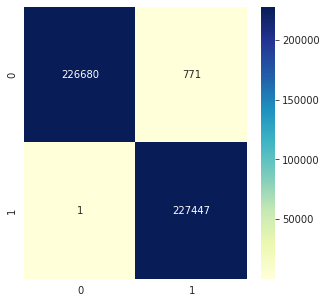

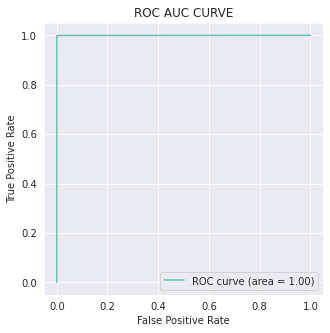

In [102]:
# Predictions on the train set
y_train_pred = optimal_XGBmodel_balanced_adasyn.predict(X_train_adasyn)
performance_scores(y_train_adasyn, y_train_pred)

y_train_pred_proba = optimal_XGBmodel_balanced_adasyn.predict_proba(X_train_adasyn)[:,1]
performance_data = draw_roc("Train","ADASYN_balanced_XGB_Model",performance_data,y_train_adasyn,y_train_pred_proba)

F1 Score:  38.29
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.87      0.38        98

    accuracy                           1.00     56962
   macro avg       0.62      0.93      0.69     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


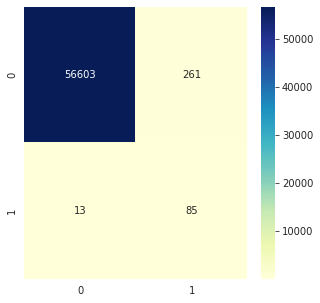

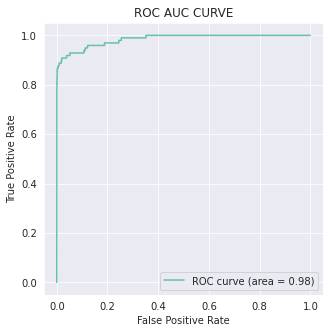

In [103]:
# Predictions on the Test set
y_test_pred = optimal_XGBmodel_balanced_adasyn.predict(X_test)
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_XGBmodel_balanced_adasyn.predict_proba(X_test)[:,1]
performance_data = draw_roc("Test","ADASYN_balanced_XGB_Model",performance_data,y_test,y_test_pred_proba)

In [104]:
performance_data[performance_data['Dataset Type']=='Test']

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Test,Unbalanced_LR_Model,0.981606
0,Test,Unbalanced_DT_Model,0.955038
0,Test,Unbalanced_XGB_Model,0.988414
0,Test,ROS_balanced_LR_Model,0.980023
0,Test,ROS_balanced_DT_Model,0.892339
0,Test,ROS_balanced_XGB_Model,0.979970
0,Test,SMOTE_balanced_LR_Model,0.976262
0,Test,SMOTE_balanced_DT_Model,0.946680
0,Test,SMOTE_balanced_XGB_Model,0.982618
0,Test,ADASYN_balanced_LR_Model,0.975901


In [105]:
performance_data[performance_data['Dataset Type']=='Test'].sort_values('ROC_AUC_SCORE',ascending=False)

,Dataset Type,Model Description,ROC_AUC_SCORE
0,Test,Unbalanced_XGB_Model,0.988414
0,Test,ADASYN_balanced_XGB_Model,0.984328
0,Test,SMOTE_balanced_XGB_Model,0.982618
0,Test,Unbalanced_LR_Model,0.981606
0,Test,ROS_balanced_LR_Model,0.980023
0,Test,ROS_balanced_XGB_Model,0.979970
0,Test,SMOTE_balanced_LR_Model,0.976262
0,Test,ADASYN_balanced_LR_Model,0.975901
0,Test,Unbalanced_DT_Model,0.955038
0,Test,ADASYN_balanced_DT_Model,0.953436


## **ADASYN BALANCED DATA**

---

#### **As we can see from the above table XG Boost model gives us the best result out of the 3 models tested on ADASYN balanced data .**

#### **ROC-AUC score on the train data is 99.99% and on test data 98.43%**

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

# **As we can see out of the 3 BALANCED MODELS the best performing model is - ADASYN**

F1 Score:  38.29
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.87      0.38        98

    accuracy                           1.00     56962
   macro avg       0.62      0.93      0.69     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 


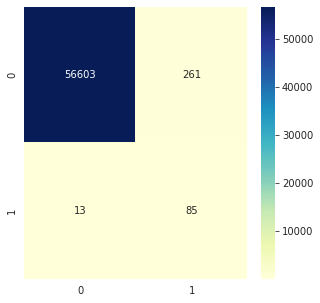

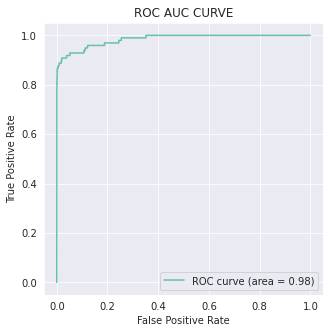

In [106]:
# perform the best oversampling method on X_train & y_train

clf = optimal_XGBmodel_balanced_adasyn  #initialise the model with optimum hyperparameters

# Predictions on the Test set
y_test_pred = clf.predict(X_test) 
performance_scores(y_test, y_test_pred)

y_test_pred_proba = optimal_XGBmodel_balanced_adasyn.predict_proba(X_test)[:,1]
performance_data = draw_roc("FINAL","ADASYN_balanced_XGB_Model",performance_data,y_test,y_test_pred_proba) #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset

Top var = 14
2nd Top var = 4
3rd Top var = 8


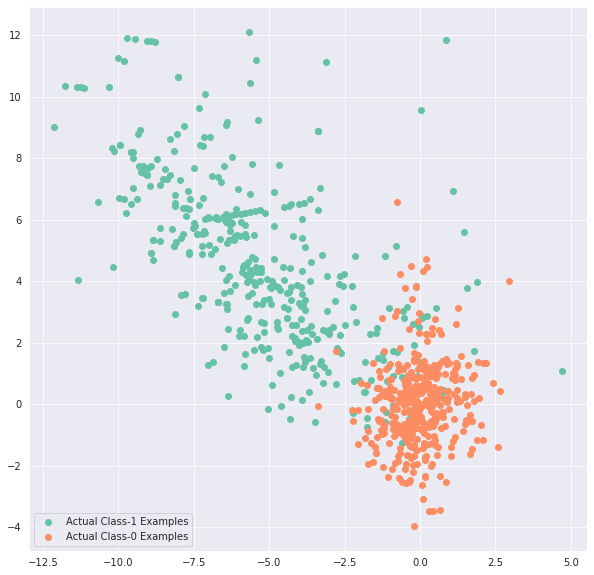

In [107]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

In [108]:
#### Print the FPR,TPR & select the best threshold from the roc curve

# Predicted probability
y_train_pred_proba = clf.predict_proba(X_train_adasyn)[:,1]

print('Train auc =', metrics.roc_auc_score(y_train_adasyn, y_train_pred_proba))
fpr, tpr, thresholds = metrics.roc_curve(y_train_adasyn, y_train_pred_proba)
threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold=",threshold)

Train auc = 0.9999109780118168
Threshold= 0.77436453


##**Selecting the best Performing model on the various balanced datasets**

---


The data used had unbalanced classes due to the nature of the data collected. We used various techniques to balance the data such as -

1. Over Sampling
2. SMOTE
3. ADASYN 

On each of the above baanced datasets we used the following modeling techniques to get the best results - 

1. Logistic Regression
2. Decision Tree
3. XG Boost

As we can see from the results of each of the above models on the train and the test dataset every Model performed well.

**from the above tests and analysis we can conclude that the XG Boost model with ADASYN Balancing was one of the best performing modes.**